<a href="https://colab.research.google.com/github/jishnubiswas20/Assignment_DHINEU_Colab/blob/main/Assignment_DHINEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Buffer creation from user defined latitude and longitude and spectral indices calculation.

In [ ]:
import ee
import json
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [ ]:
ee.Authenticate()


In [ ]:
ee.Initialize(project='carbide-sensor-434209-k7')

In [ ]:
import folium
import geopandas as gpd
from shapely.geometry import Point




In [ ]:
# Latitude and longitude of the point
lat, lon = 23.861443376832728, 91.34147139064376
# Create a point geometry
point = Point(lon, lat)
# Create a GeoDataFrame in WGS 84 (EPSG:4326)
gdf = gpd.GeoDataFrame([1], geometry=[point], crs="EPSG:4326")
# Reproject the GeoDataFrame to a suitable UTM CRS (e.g., EPSG:32646 for UTM zone 46N)
gdf = gdf.to_crs("EPSG:32646")
# Define the buffer distance in meters (e.g., 5000 meters for ~5km)
buffer_distance = 5000
# Create the buffer in the projected CRS
buffer = gdf.buffer(buffer_distance)
# Reproject the buffer back to WGS 84 (EPSG:4326) for visualization in Folium
buffer = buffer.to_crs("EPSG:4326")
# Create a Folium map centered on the original point
mymap = folium.Map(location=[lat, lon], zoom_start=12)
# Convert the buffer to GeoJSON and add it to the map
folium.GeoJson(buffer).add_to(mymap)
# Optionally, add a marker at the original point
folium.Marker([lat, lon], popup='Center Point').add_to(mymap)
# Display the map directly in Google Colab
mymap

In [ ]:
# Convert the buffer to a GeoJSON format (as a dictionary)
buffer_geojson = json.loads(buffer.to_json())

# Extract the 'geometry' part of the GeoJSON
geometry = buffer_geojson['features'][0]['geometry']

In [ ]:
# Create the Earth Engine Geometry from the extracted GeoJSON geometry
study_area = ee.Geometry(geometry)


In [ ]:
# Define the date range for the analysis
start_date = '2023-01-10'
end_date = '2023-01-20'

# Load Sentinel-2 image collection, filter by date, and location
sentinel2 = (ee.ImageCollection('COPERNICUS/S2')
             .filterDate(start_date, end_date)
             .filterBounds(study_area)
             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to calculate NDWI
def calculate_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

# Apply the functions to the image collection
sentinel2 = sentinel2.map(calculate_ndvi).map(calculate_ndwi)

# Reduce to a single image (mean)
mean_image = sentinel2.mean()

# Clip to study area
clipped_image = mean_image.clip(study_area)

# Display NDVI and NDWI on the map
Map = geemap.Map()
Map.centerObject(study_area, zoom=12)
Map.addLayer(clipped_image.select('NDVI'), {'min': 0, 'max': 1, 'palette': ['#ffffff', '#008000', '#3aee58', '#3aee58', '#01460d']}, 'NDVI')
Map.addLayer(clipped_image.select('NDWI'), {'min':-0.1275748312473297, 'max': -0.03738724812865257, 'palette': ['#ffffff', '#e3e5f2', '#a9b3f4', '#182fe2', '#0000ff']}, 'NDWI')
Map

Map(center=[23.861443250301843, 91.34147190105233], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
sentinel2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
             .filterDate(start_date, end_date)
             .filterBounds(study_area)
             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).select(['B4', 'B3', 'B2']).mean().clip(study_area))
# Define visualization parameters
rgb_vis = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],
    'gamma': 1.4,
}
Map.addLayer(sentinel2,rgb_vis, 'RGB')

Map

# Define export parameters
export_params = {
    'scale': 10,  # Export at 10 meters resolution
    'region': study_area,  # Define the region to export
    'fileFormat': 'GeoTIFF'
}

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(image=sentinel2,
                                     description='sentinel2',
                                     fileNamePrefix='sentinel_rgb',
                                     **export_params)

# Start the export task
task.start()

print("Exporting Sentinel-2 RGB image to Google Drive. Check your Drive folder for the file.")


Exporting Sentinel-2 RGB image to Google Drive. Check your Drive folder for the file.


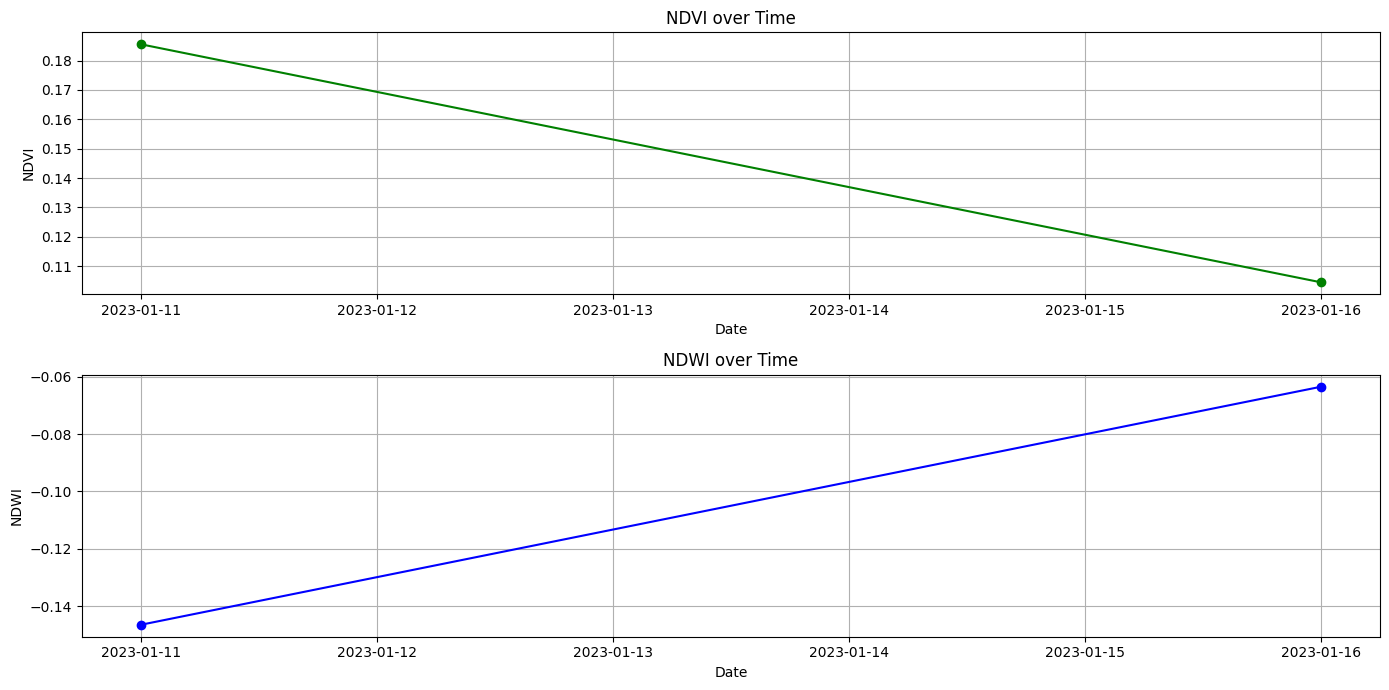

NDVI Statistics:
 count    2.000000
mean     0.145022
std      0.057319
min      0.104491
25%      0.124756
50%      0.145022
75%      0.165287
max      0.185552
Name: NDVI, dtype: float64

NDWI Statistics:
 count    2.000000
mean    -0.104984
std      0.058701
min     -0.146492
25%     -0.125738
50%     -0.104984
75%     -0.084230
max     -0.063476
Name: NDWI, dtype: float64


In [ ]:
# Step 1: Load and Filter the Sentinel-2 Imagery
start_date = '2023-01-10'
end_date = '2023-01-20'

sentinel2 = (ee.ImageCollection('COPERNICUS/S2')
             .filterDate(start_date, end_date)
             .filterBounds(study_area)
             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
             .map(calculate_ndvi)
             .map(calculate_ndwi))

# Step 2: Extract NDVI and NDWI Values Over Time
def extract_ndvi_ndwi(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    mean_ndvi = image.select('NDVI').reduceRegion(ee.Reducer.median(), study_area, scale=10).get('NDVI')
    mean_ndwi = image.select('NDWI').reduceRegion(ee.Reducer.median(), study_area, scale=10).get('NDWI')
    return ee.Feature(None, {'date': date, 'NDVI': mean_ndvi, 'NDWI': mean_ndwi})

# Apply the function to the collection
ndvi_ndwi_collection = sentinel2.map(extract_ndvi_ndwi)

# Convert to a list of dictionaries
ndvi_ndwi_dict = ndvi_ndwi_collection.getInfo()['features']

# Create a DataFrame from the list of dictionaries
data = {
    'date': [feature['properties']['date'] for feature in ndvi_ndwi_dict],
    'NDVI': [feature['properties']['NDVI'] for feature in ndvi_ndwi_dict],
    'NDWI': [feature['properties']['NDWI'] for feature in ndvi_ndwi_dict],
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Step 3: Plot the Line Graphs
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df['date'], df['NDVI'], marker='o', color='green')
plt.title('NDVI over Time')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['date'], df['NDWI'], marker='o', color='blue')
plt.title('NDWI over Time')
plt.xlabel('Date')
plt.ylabel('NDWI')
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 4: Provide a Statistical Report
ndvi_stats = df['NDVI'].describe()
ndwi_stats = df['NDWI'].describe()

print("NDVI Statistics:\n", ndvi_stats)
print("\nNDWI Statistics:\n", ndwi_stats)

CNN Model For Lulc classification.

In [ ]:
!pip install tensorflow geopandas rasterio
!pip install sentinelsat
!pip install gdal
!pip install keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.5 MB/s eta 0:00:00
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33111 sha256=2224861dd1ce848eaae416a89a22be9603e8cb13d331f288405a793167849cae
  Stored in directory: /root/.cache/pip/wheels/f3/96/6d/a7eba8f80d31cbd188a2787b81514d82fc5ae6943c44777659
Successfully built html2text


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models


In [ ]:
# Load the EuroSAT dataset
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.7WHRLW_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Get training and testing datasets
train_ds = dataset['train']

# Get the class names
class_names = info.features['label'].names
print(class_names)


['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
# Data normalization for traingng
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize_img)


In [ ]:
# Defie the trainng batch
batch_size = 32
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(1)


In [ ]:
# Developing the CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes in EuroSAT
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model with dataset.
history = model.fit(train_ds, epochs=5)

Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 210s 246ms/step - accuracy: 0.4413 - loss: 1.4581
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 200s 236ms/step - accuracy: 0.7276 - loss: 0.7580
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 200s 237ms/step - accuracy: 0.7775 - loss: 0.6131
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 200s 235ms/step - accuracy: 0.8176 - loss: 0.5078
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 200s 237ms/step - accuracy: 0.8397 - loss: 0.4539


In [ ]:
# Define the EuroSAT class names
class_names = [
    'Annual Crop',
    'Forest',
    'Herbaceous Vegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'Permanent Crop',
    'Residential',
    'River',
    'Sea/Lake'
]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

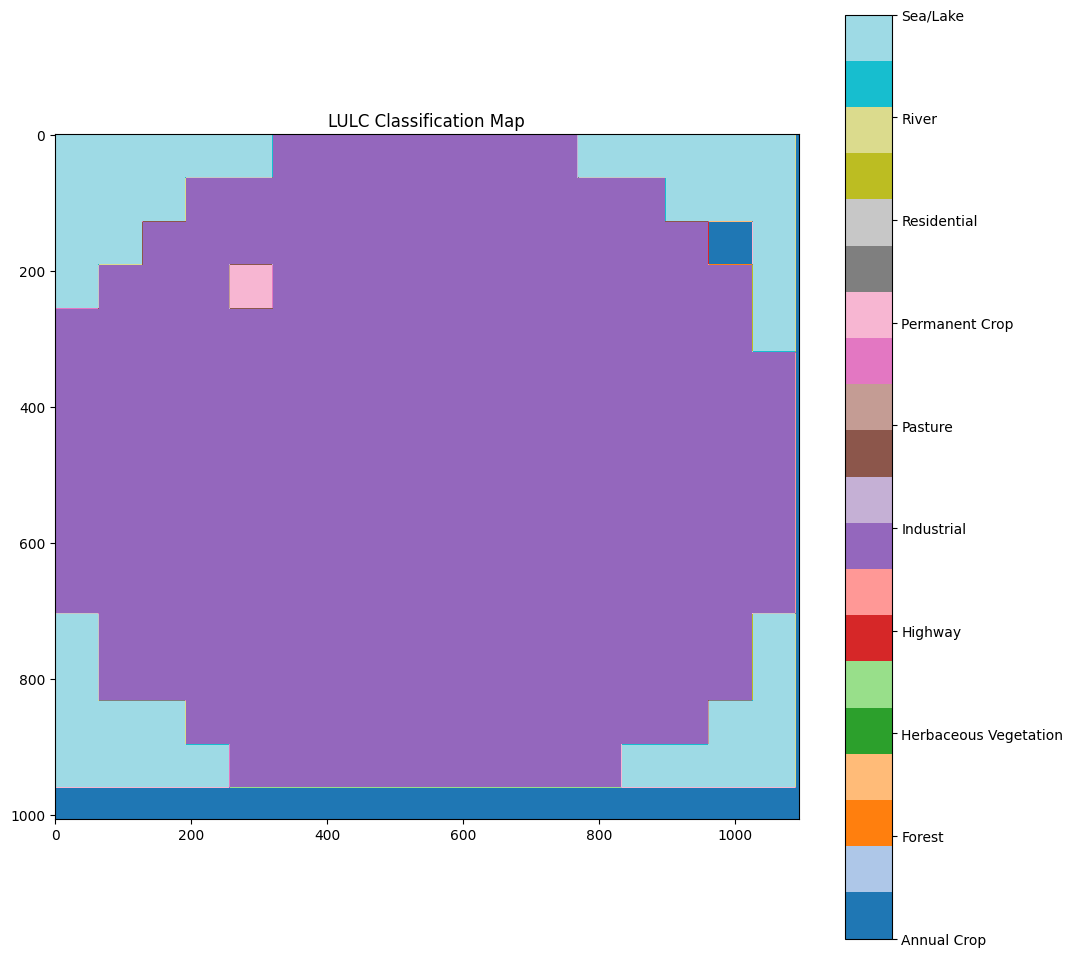

In [ ]:
import rasterio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the Sentinel-2 RGB image
with rasterio.open('/content/drive/MyDrive/sentinel_rgb.tif') as src:
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)

    # Stack the bands into a single array
    img = np.stack([red, green, blue], axis=-1)

# Parameters for tiling
tile_size = 64  # Size of the patch (should match model input)
height, width, _ = img.shape

# Create an empty array to hold the predictions
lulc_map = np.zeros((height, width), dtype=np.uint8)

# Loop through the image with a sliding window
for i in range(0, height, tile_size):
    for j in range(0, width, tile_size):
        # Extract the patch
        patch = img[i:i + tile_size, j:j + tile_size, :]

        # Handle edge cases where the patch is smaller than the tile_size
        if patch.shape[0] != tile_size or patch.shape[1] != tile_size:
            continue  # Skip tiles that are not the full tile_size

        # Resize and normalize the patch
        patch_resized = tf.image.resize(patch, [tile_size, tile_size])
        patch_normalized = patch_resized / 255.0
        patch_expanded = np.expand_dims(patch_normalized, axis=0)

        # Predict the class for the patch
        predictions = model.predict(patch_expanded)
        predicted_class = np.argmax(predictions, axis=-1)[0]

        # Fill the corresponding area in the LULC map with the predicted class
        lulc_map[i:i + tile_size, j:j + tile_size] = predicted_class

# Convert the LULC map to class names
lulc_map_named = np.vectorize(lambda x: class_names[x])(lulc_map)

# Plot the LULC map with class names
plt.figure(figsize=(12, 12))
plt.imshow(lulc_map, cmap='tab20')
plt.title('LULC Classification Map')
plt.colorbar(ticks=np.arange(len(class_names)), format=plt.FuncFormatter(lambda val, loc: class_names[int(val)]))
plt.show()
